# DeepFakes Task 2 - Model 1

Here only the features are extracted. The final model will be the combination of these with the ones extracted in the notebook Task2 - Model 2.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import dlib
import seaborn as sns

from google.colab import drive
from skimage.morphology import convex_hull_image
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# Create dataset

Load files stored in Google Drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Create paths to the folders and files for training and test

In [3]:
root_dir = "/content/drive/MyDrive/PDBR/Dataset/Task_2_3"
sub_folding = ["evaluation"]
categories = ['real', "fake"]

eva_real = []
eva_fake = []

for root, dirs, files in os.walk(root_dir, topdown=True):
  for name in files:
    path = os.path.join(root, name)
    if '.jpg' in path and 'evaluation' in path and 'real' in path:
      eva_real.append(path)
    elif '.jpg' in path and 'evaluation' in path and 'fake' in path:
      eva_fake.append(path)

print('Real evaluation instances: ', len(eva_real))
print('Fake evaluation instances: ', len(eva_fake))

Real evaluation instances:  300
Fake evaluation instances:  300


Display images

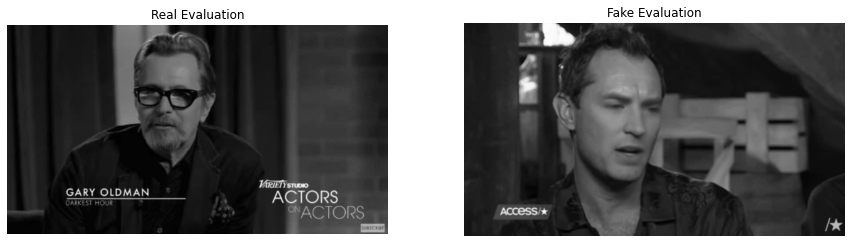

In [16]:
# The images are not loaded in order
f, axarr = plt.subplots(1, 2, figsize=(15,10))

ima_eva_real = cv2.imread(eva_real[54], cv2.IMREAD_GRAYSCALE)
axarr[0].imshow(ima_eva_real, cmap = "gray")
axarr[0].axis('off')
axarr[0].set_title('Real Evaluation')

ima_eva_fake = cv2.imread(eva_fake[32], cv2.IMREAD_GRAYSCALE)
axarr[1].imshow(ima_eva_fake, cmap = "gray")
axarr[1].axis('off')
axarr[1].set_title('Fake Evaluation')

plt.show()

# Feature Extraction

### Detect face

Load face detector (external)

In [5]:
# download if missing http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
def load_facedetector():
    """Loads dlib face and landmark detector."""
    
    if not os.path.isfile(root_dir+'/shape_predictor_68_face_landmarks.dat'):
        print ('Could not find shape_predictor_68_face_landmarks.dat.')
        exit(-1)
    face_detector = dlib.get_frontal_face_detector()
    sp68 = dlib.shape_predictor(root_dir+'/shape_predictor_68_face_landmarks.dat')

    return face_detector, sp68

face_detector, sp68 = load_facedetector()

Extract landmarks

In [6]:
def shape_to_np(shape):
    number_of_points = shape.num_parts
    points = np.zeros((number_of_points, 2), dtype=np.int32)
    for i in range(0, number_of_points):
        points[i] = (shape.part(i).x, shape.part(i).y)

    return points
    
def get_crops_landmarks(facedetector, sp68, img, roi_delta=0.0, min_score=0.0):
    """Detects faces and landmarks in image, crops image to face region."""
    face_crops = []
    final_landmarks = []

    dets, scores, idx = facedetector.run(img, 0, 0)

    num_faces = len(dets)
    if num_faces == 0:
        return face_crops, final_landmarks

    # extract especially frontal faces
    if min_score > 0.0:
        dets_new = []
        for i in range(len(dets)):
            if scores[i] > min_score:
                dets_new.append(dets[i])
        dets = dets_new

    # detect landmarks and transform to np array
    landmarks = []
    for detection in dets:
        sp_result = sp68(img, detection)
        landmarks.append(shape_to_np(sp_result))

    # crop faces
    for num in range(len(dets)):
        # copy landmarks and get crop
        face_roi = dets[num]
        face_roi = dlib.rectangle(max(0, face_roi.left()), max(0, face_roi.top()), max(0, face_roi.right()),
                                 max(0, face_roi.bottom()))

        # extend face ROI if needed
        delta_percent = roi_delta
        height = face_roi.bottom() - face_roi.top()
        delta = int(delta_percent * height)
        extended_roi_top = np.clip(face_roi.top() - delta, 0, img.shape[0])
        extended_roi_bottom = np.clip(face_roi.bottom() + delta, 0, img.shape[0])
        extended_roi_left = np.clip(face_roi.left() - delta, 0, img.shape[1])
        extended_roi_right = np.clip(face_roi.right() + delta, 0, img.shape[1])
        cropped_face = img[extended_roi_top:extended_roi_bottom, extended_roi_left:extended_roi_right, :]

        face_landmarks = landmarks[num].copy()

        face_landmarks[:, 0] = face_landmarks[:, 0] - extended_roi_left
        face_landmarks[:, 1] = face_landmarks[:, 1] - extended_roi_top

        final_landmarks.append(face_landmarks)
        face_crops.append(cropped_face)

    return face_crops, final_landmarks

### Utils for resize and extract masks

In [7]:
def new_size(org_x, org_y, large_dim=600):
    ratio = float(org_x) / float(org_y)

    if org_x > org_y:
        out_size = (int(large_dim / ratio), large_dim)
    else:
        out_size = (large_dim, int(large_dim * ratio))

    return out_size

def generate_convex_mask(shape, points_x, points_y):
    mask = np.zeros(shape, dtype=np.uint8)

    #clip to image size
    points_x = np.clip(points_x, 0, max(0, shape[1] - 1))
    points_y = np.clip(points_y, 0, max(0, shape[0] - 1))

    #set mask pixels
    mask[points_y, points_x] = 255
    mask = convex_hull_image(mask)

    return mask

### Definition of Laws filters

In [8]:
LAWS = {'L5': [1, 4, 6, 4, 1], 'E5': [-1, -2, 0, 2, 1], 'S5': [-1, 0, 2, 0, -1], 'R5': [1, -4, 6, -4, 1]}


def generate_law_filters():
    law_masks = {}
    for type1, vector1 in LAWS.items():
        for type2, vector2 in LAWS.items():
            mask_type = type1+type2
            filter_mask = np.asarray(vector1)[:, np.newaxis].T * np.asarray(vector2)[:, np.newaxis]
            law_masks[mask_type] = filter_mask

    return law_masks


def generate_mean_kernel(size):
    mean_kernel = np.ones((size, size), dtype=np.float32)
    mean_kernel = mean_kernel / mean_kernel.size

    return mean_kernel


def preprocess_image(img, size=15):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mean_kernel = generate_mean_kernel(size)
    local_means = cv2.filter2D(img, -1, mean_kernel)
    local_zero_mean_img = img - local_means

    return local_zero_mean_img


def filter_image(img, law_masks):
    law_images = {}
    for name, filter_kernel in law_masks.items():
        filtered_img = cv2.filter2D(img, -1, filter_kernel)
        law_images[name] = filtered_img

    return law_images


def compute_energy(law_images, m_size):
    laws_energy = {}
    mean_kernel = generate_mean_kernel(m_size)

    for name, law_image in law_images.items():
        law_image = np.abs(law_image)
        energy_image = cv2.filter2D(law_image, -1, mean_kernel)
        laws_energy[name] = energy_image

    laws_energy_final = {}
    laws_energy_final['L5E5_2'] = (laws_energy['L5E5'] + laws_energy['E5L5']) / 2.0
    laws_energy_final['L5R5_2'] = (laws_energy['L5R5'] + laws_energy['R5L5']) / 2.0
    laws_energy_final['E5S5_2'] = (laws_energy['S5E5'] + laws_energy['E5S5']) / 2.0
    laws_energy_final['L5S5_2'] = (laws_energy['S5L5'] + laws_energy['L5S5']) / 2.0
    laws_energy_final['E5R5_2'] = (laws_energy['E5R5'] + laws_energy['R5E5']) / 2.0
    laws_energy_final['S5R5_2'] = (laws_energy['S5R5'] + laws_energy['R5S5']) / 2.0
    laws_energy_final['S5S5'] = laws_energy['S5S5']
    laws_energy_final['R5R5'] = laws_energy['R5R5']
    laws_energy_final['E5E5'] = laws_energy['E5E5']

    return laws_energy_final

LAW_MASKS = generate_law_filters()

### Process eyes and extract features

In [9]:
LANDMARKS = {"mouth": (48, 68),
             "mouth_inner": (60, 68),
             "right_eyebrow":(17, 22),
             "left_eyebrow": (22, 27),
             "right_eye": (36, 42),
             "left_eye": (42, 48),
             "nose": (27, 35),
             "jaw": (0, 17),
             }

LEYE_LM = np.arange(LANDMARKS["left_eye"][0], LANDMARKS["left_eye"][1])
REYE_LM = np.arange(LANDMARKS["right_eye"][0], LANDMARKS["right_eye"][1])

def extract_features_mask(img, mask):
    """Computes law texture features for masked area of image."""
    preprocessed_img = preprocess_image(img, size=15)
    law_images = filter_image(preprocessed_img, LAW_MASKS)
    law_energy = compute_energy(law_images, 10)

    energy_features_list = []
    for type, energy in law_energy.items():
        # extract features for mask
        energy_masked = energy[np.where(mask != 0)]
        energy_feature = np.mean(energy_masked, dtype=np.float32)
        energy_features_list.append(energy_feature)

    return energy_features_list

def extract_features_eyes(landmarks, face_crop, scale=256):
    # generate mask for eyes
    l_eye_marks = landmarks[LEYE_LM]
    r_eye_marks = landmarks[REYE_LM]
    l_eye_mask = generate_convex_mask(face_crop[..., 0].shape, l_eye_marks[..., 0], l_eye_marks[..., 1])
    r_eye_mask = generate_convex_mask(face_crop[..., 0].shape, r_eye_marks[..., 0], r_eye_marks[..., 1])
    eye_mask = np.logical_or(l_eye_mask, r_eye_mask)
    eye_mask = eye_mask.astype(dtype=np.uint8)

    # resize input
    out_size = new_size(face_crop.shape[1], face_crop.shape[0], large_dim=scale)
    eye_mask = cv2.resize(eye_mask, (out_size[1], out_size[0]), interpolation=cv2.INTER_NEAREST)
    face_crop = cv2.resize(face_crop, (out_size[1], out_size[0]), interpolation=cv2.INTER_LINEAR)

    #segmentation fail
    if np.sum(eye_mask) < 10:
        return None

    energy_features = extract_features_mask(face_crop, eye_mask)

    return energy_features

    
def process_faces(face_crop_list, landmarks_list, scale=256):
  final_feature_vector_0 = None

  for num in range(len(face_crop_list)):
    landmarks = landmarks_list[num].copy()
    face_crop = face_crop_list[num]

    features_0 = extract_features_eyes(landmarks, face_crop, scale=scale)
      
    if features_0 is not None:
      final_feature_vector_0 = features_0 

  valid_segmentation = final_feature_vector_0 is not None

  return final_feature_vector_0, valid_segmentation

### Features extraction for the dataset

In [10]:
def getFaceLandmarks(path): 
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  extend_roi = 0.0
  face_crops, final_landmarks = get_crops_landmarks(face_detector, sp68, img,
                                                    roi_delta=extend_roi)
  return face_crops, final_landmarks

In [11]:
feat_names = ['label', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9']
test_size = len(eva_real)+len(eva_fake)

data_test = np.zeros((test_size, len(feat_names)), dtype=np.float32)

j = 0
discard_eva = 0
for path in eva_fake:
  face_crops, final_landmarks = getFaceLandmarks(path)
  feature_vector, valid = process_faces(face_crops, final_landmarks, scale=256) 

  if not valid:
    feature_vector = [float('nan')]*(len(feat_names)-1)
    discard_eva+=1
  feature_vector.insert(0,0)
  data_test[j, :] = feature_vector
  j = j+1

for path in eva_real:
  face_crops, final_landmarks = getFaceLandmarks(path)
  feature_vector, valid = process_faces(face_crops, final_landmarks, scale=256) 
  
  if not valid:
    feature_vector = [float('nan')]*(len(feat_names)-1)
    discard_eva+=1
  feature_vector.insert(0,1)
  data_test[j, :] = feature_vector
  j = j+1

print(len(data_test))
print('Discarded in evaluation dataset', discard_eva)

600
Discarded in evaluation dataset 13


In [12]:
# Convert to dataframe
df_test = pd.DataFrame(data=data_test, columns=feat_names)

Save features as CSV

In [13]:
df_test.to_csv(os.path.join(root_dir, 'test_data.csv'), index=False)